In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Input, add, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

RANDOM_SEED = 42
random.seed(RANDOM_SEED)


c:\Users\Theo\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Theo\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
c:\Users\Theo\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
vitals = pd.read_csv('vitals.csv')  
labs = pd.read_csv('labs.csv')  

Changing the date to datetime variable and setting indexes

In [3]:
vitals['charttime'] = pd.to_datetime(vitals['charttime'] , infer_datetime_format=True)
labs['charttime'] = pd.to_datetime(labs['charttime'] , infer_datetime_format=True)

In [4]:
vitals_48hours_grouped = vitals.groupby('icustay_id').tail(48)

In [5]:
labs_48hours_grouped = labs.groupby('icustay_id').tail(6)

In [6]:
print((vitals_48hours_grouped.icustay_id.value_counts() == 48).sum() == len(vitals_48hours_grouped) /48)
print((labs_48hours_grouped.icustay_id.value_counts() == 6).sum() == len(labs_48hours_grouped) /6)

True
True


In [7]:
vitals_48hours_grouped = vitals_48hours_grouped.drop(['icustay_id','charttime'], axis=1)
labs_48hours_grouped = labs_48hours_grouped.drop(['icustay_id','charttime'], axis=1)

In [8]:
vitals_features = vitals_48hours_grouped.iloc[:,:-1]
vitals_labels = vitals_48hours_grouped.iloc[:,-1:].to_numpy().tolist()

In [9]:
labs_features = labs_48hours_grouped.iloc[:,:-1]
labs_labels = labs_48hours_grouped.iloc[:,-1:].to_numpy().tolist()

# Federated Learning Setup

In [10]:
import math

def create_clients(labs_data, vitals_data, label_list, num_clients=4, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(labs_data, vitals_data))
    data = list(zip(data, label_list))
    random.shuffle(data)
    client1_data_size = math.ceil(len(data) * 0.35)
    client2_data_size = math.ceil(len(data) * 0.3) + client1_data_size
    client3_data_size = math.ceil(len(data) * 0.2) + client2_data_size
    client4_data_size = math.ceil(len(data) * 0.15) + client3_data_size

    #shard data and place at each client
    shards = [data[0:client1_data_size], data[client1_data_size:client2_data_size],
              data[client2_data_size:client3_data_size],data[client3_data_size:client4_data_size]]
    #size = len(data)//num_clients
    #shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))
    
    return  {client_names[i] : shards[i] for i in range(len(client_names))}

## Reshaping data and preparing them for cross validation

In [11]:
vitals_labels = np.array(vitals_labels)
labs_labels = np.array(labs_labels)


labs_labels_reshaped = np.reshape(labs_labels, (19414,6))
labs_labels_reshaped = np.amax(labs_labels_reshaped, axis=1)

vitals_labels_reshaped = np.reshape(vitals_labels, (19414,48))
vitals_labels_reshaped = np.amax(vitals_labels_reshaped, axis=1)
print(labs_labels_reshaped.shape)
print(vitals_labels_reshaped.shape)

(19414,)
(19414,)


In [12]:
vitals_features_reshaped = np.reshape(vitals_features.values, (19414,48,7))
print(vitals_features_reshaped.shape)
labs_features_reshaped = np.reshape(labs_features.values, (19414,6,16))
print(labs_features_reshaped.shape)

(19414, 48, 7)
(19414, 6, 16)


### Batching clients and test data

In [13]:
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = []
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=RANDOM_SEED, stratify=label)
    X_labs_train , X_vitals_train = zip(*X_train)
    X_labs_test , X_vitals_test = zip(*X_test)

    #Reshaping to standardize the laboratory values
    X_labs_train = np.array(X_labs_train)
    X_labs_test = np.array(X_labs_test)
    samples_train, groupedBy_train, sample_values_train = X_labs_train.shape
    samples_test, groupedBy_test, sample_values_test = X_labs_test.shape
    X_labs_train_reshaped = np.reshape(X_labs_train, (samples_train*groupedBy_train, sample_values_train))
    X_labs_test_reshaped = np.reshape(X_labs_test, (samples_test*groupedBy_test, sample_values_test))
    #Standardizing the laboratory values
    scaler_labs = StandardScaler()
    scaler_labs = scaler_labs.fit(X_labs_train_reshaped)
    X_labs_train_reshaped = scaler_labs.transform(X_labs_train_reshaped)
    X_labs_test_reshaped = scaler_labs.transform(X_labs_test_reshaped)
    #Reshaping again
    X_labs_train = np.reshape(X_labs_train_reshaped,  (samples_train, groupedBy_train, sample_values_train))
    X_labs_test = np.reshape(X_labs_test_reshaped, (samples_test, groupedBy_test, sample_values_test))

    #Reshaping to standardize the laboratory values
    X_vitals_train = np.array(X_vitals_train)
    X_vitals_test = np.array(X_vitals_test)
    samples_train, groupedBy_train, sample_values_train = X_vitals_train.shape
    samples_test, groupedBy_test, sample_values_test = X_vitals_test.shape
    X_vitals_train_reshaped = np.reshape(X_vitals_train, (samples_train*groupedBy_train, sample_values_train))
    X_vitals_test_reshaped = np.reshape(X_vitals_test, (samples_test*groupedBy_test, sample_values_test))
    #Standardizing the laboratory values
    scaler_vitals = StandardScaler()
    scaler_vitals = scaler_vitals.fit(X_vitals_train_reshaped)
    X_vitals_train_reshaped = scaler_vitals.transform(X_vitals_train_reshaped)
    X_vitals_test_reshaped = scaler_vitals.transform(X_vitals_test_reshaped)
    #Reshaping again
    X_vitals_train = np.reshape(X_vitals_train_reshaped,  (samples_train, groupedBy_train, sample_values_train))
    X_vitals_test = np.reshape(X_vitals_test_reshaped, (samples_test, groupedBy_test, sample_values_test))

    combinedDatasetTraining = tf.data.Dataset.from_tensor_slices(({"Input_1": list(X_labs_train), "Input_2": list(X_vitals_train)}, list(y_train)))
    combinedDatasetTraining = combinedDatasetTraining.shuffle(len(y_train)).batch(bs)
    combinedDatasetTesting = tf.data.Dataset.from_tensor_slices(({"Input_1": list(X_labs_test), "Input_2": list(X_vitals_test)}, list(y_test)))
    combinedDatasetTesting = combinedDatasetTesting.shuffle(len(y_test)).batch(bs)
    
    dataset.append(combinedDatasetTraining)
    dataset.append(combinedDatasetTesting)
    return dataset

### Creating the Model

In [14]:
class RNNModel:
    @staticmethod
    def build():
     input1 = Input(shape=(6,16), name='Input_1')
     fe1 = LSTM(16, input_shape= (6,16), return_sequences=True)(input1)
     fe2 = LSTM(16, return_sequences=True)(fe1)
     fe3 = LSTM(16)(fe2)
#sequence model
     input2 = Input(shape=(48,7), name='Input_2')
     se1 = LSTM(16, input_shape= (48,7), return_sequences=True)(input2)
     se2 = LSTM(16, return_sequences=True)(se1)
     se3 = LSTM(16)(se2)
#decoder model
     decoder1 = concatenate([fe3, se3])
     decoder2 = Dense(16, activation='relu')(decoder1)
     decoder3 = Dense(16, activation='relu')(decoder2)
     output = Dense(1, activation='sigmoid')(decoder3)
#connecting the two models
     model = Model(inputs=[input1, input2], outputs=output)
     return model

### Federated Averaging

In [15]:
def weight_scalling_factor(clients_trn_data, client_name):
    '''Gets batch size and calculates total datapoints and how many data points the client has to scale it'''
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name][0])[0][0]['Input_1'].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name][0]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name][0]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    Y_test = np.reshape(Y_test, (len(Y_test),1))
    loss = cce(Y_test, logits)
    logits = np.where(logits > 0.5, 1, 0)
    f1_score_acc = f1_score(Y_test.max(axis=1), logits.max(axis=1), average='macro')
    print('comm_round: {} | f1_score: {:.3%} | global_loss: {}'.format(comm_round, f1_score_acc, loss))
    return f1_score_acc, loss

def evaluating_model_own_validation_data(model, val_data):
    cce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    logits = model.predict(val_data)
    y_true = np.concatenate([y for x, y in val_data], axis=0)
    y_true = np.reshape(y_true, (len(y_true),1))
    partial_loss = binary_crossentropy_partial(y_true, logits)
    loss = cce(y_true, logits)
    logits = np.where(logits > 0.5, 1, 0)
    return partial_loss, loss, len(logits)

def binary_crossentropy_partial(y_true, y_pred):
    #(y_true * (np.log(y_pred))) + (1.0 - y_true) * np.log(1.0 - y_pred)
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + + 1e-7)
    term_1 = y_true * np.log(y_pred  + 1e-7)
    return np.sum(term_0 + term_1, axis=0)
    


In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
skf.get_n_splits(vitals_features_reshaped, vitals_labels_reshaped)

5

### Training the model - Each client validate on their own data

In [17]:
loss_CV = []
acc_CV = []
partial_loss_values_averages_all = []
loss_values_averages_all = []
clients_number = 4
patience = 30
best_models = []
early_stopping_applied = []
test_batches_CV = []
for train_index, test_index in skf.split(vitals_features_reshaped, vitals_labels_reshaped):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_vitals, X_test_vitals = vitals_features_reshaped[train_index], vitals_features_reshaped[test_index]
    X_train_labs, X_test_labs = labs_features_reshaped[train_index], labs_features_reshaped[test_index]
    y_train, y_test = vitals_labels_reshaped[train_index], vitals_labels_reshaped[test_index]
    clients = create_clients(X_train_labs, X_train_vitals ,y_train, num_clients=clients_number, initial='client')
    #process and batch the training data for each client
    clients_batched = dict()
    for (client_name, data) in clients.items():
        clients_batched[client_name] = batch_data(data)
    #Standardizing the testing set based on all training data
    X_train_labs = np.array(X_train_labs)
    samples_train, groupedBy_train, sample_values_train = X_train_labs.shape
    X_train_labs = np.reshape(X_train_labs, (samples_train*groupedBy_train,sample_values_train))
    samples_test, groupedBy_test, sample_values_test = X_test_labs.shape
    X_test_labs = np.reshape(X_test_labs, (samples_test*groupedBy_test,sample_values_test))
    scaler_labs = StandardScaler()
    scaler_labs = scaler_labs.fit(X_train_labs)
    X_test_labs = scaler_labs.transform(X_test_labs)
    X_test_labs = np.reshape(X_test_labs, (samples_test,groupedBy_test,sample_values_test))


    X_train_vitals = np.array(X_train_vitals)
    samples_train, groupedBy_train, sample_values_train = X_train_vitals.shape
    X_train_vitals = np.reshape(X_train_vitals, (samples_train*groupedBy_train,sample_values_train))
    samples_test, groupedBy_test, sample_values_test = X_test_vitals.shape
    X_test_vitals = np.reshape(X_test_vitals, (samples_test*groupedBy_test,sample_values_test))
    scaler_labs = StandardScaler()
    scaler_labs = scaler_labs.fit(X_train_vitals)
    X_test_vitals = scaler_labs.transform(X_test_vitals)
    X_test_vitals = np.reshape(X_test_vitals, (samples_test,groupedBy_test,sample_values_test))

    #process and batch the test set  
    test_batched = tf.data.Dataset.from_tensor_slices(({"Input_1": list(X_test_labs), 
    "Input_2": list(X_test_vitals)}, list(y_test))).batch(len(y_test))
    test_batches_CV.append(test_batched)
    #initialize global model
    partial_loss_values_averages = []
    loss_values_averages = []
    models_CV = []
    best_score = 0
    rounds_worse_than_before = 0    
    rnn_global = RNNModel()
    global_model = rnn_global.build()
    comms_round = 300
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    global_loss = []
    global_acc = []
    learning_rate = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    counter = 0
    #commence global training loop
    for comm_round in range(comms_round):
        if comm_round % 5 == 0 and comm_round > 0:
            learning_rate = learning_rate * 0.5
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        # get the global model's weights - will serve as the initial weights for all local models
        global_weights = global_model.get_weights()
        
        #initial list to collect local model weights after scalling
        scaled_local_weight_list = list()

        #randomize client data - using keys
        client_names= list(clients_batched.keys())
        random.shuffle(client_names)
        
        #loop through each client and create new local model
        for client in client_names:
            rnn_local = RNNModel()
            local_model = rnn_local.build()
            local_model.compile(loss=loss, 
                        optimizer=optimizer, 
                        metrics=metrics)
            
            #set local model weight to the weight of the global model
            local_model.set_weights(global_weights)

            #fit local model with client's data
            local_model.fit(clients_batched[client][0], epochs=3, verbose=0, validation_data=clients_batched[client][1])
            
            #scale the model weights and add to list
            scaling_factor = weight_scalling_factor(clients_batched, client)
            scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
            scaled_local_weight_list.append(scaled_weights)
            
            #clear session to free memory after each communication round
            K.clear_session()
            
        #to get the average over all the local model, we simply take the sum of the scaled weights
        average_weights = sum_scaled_weights(scaled_local_weight_list)
        
        #update global model 
        global_model.set_weights(average_weights)

        #evaluating the current global model against each clients validation data
        partial_loss_values = 0
        loss_values = 0
        total_number_of_samples = 0
        for client in client_names:
            rnn_local = RNNModel()
            local_model = rnn_local.build()
            local_model.compile(loss=loss, 
                        optimizer=optimizer, 
                        metrics=metrics)     
            #set local model weight to the weight of the global model
            local_model.set_weights(global_weights)
            partial_loss_value, loss_value, number_of_samples = evaluating_model_own_validation_data(local_model, clients_batched[client][1])
            loss_values += loss_value
            partial_loss_values += partial_loss_value
            total_number_of_samples += number_of_samples
            print(partial_loss_value)
            print(number_of_samples)
        partial_loss_values = partial_loss_values / (-total_number_of_samples)
        partial_loss_values = partial_loss_values[0]
        loss_values = loss_values / clients_number
        print("F1 Score average for round {} = {}, Loss: {}".format(comm_round, partial_loss_values, loss_values))
        models_CV.append(global_model)
        partial_loss_values_averages.append(partial_loss_values)
        loss_values_averages.append(loss_values)
        if  len(partial_loss_values_averages) == 1:
            best_score = partial_loss_values_averages[0]
        #checks for early stopping according to f1 score and patience
        if len(partial_loss_values_averages) > 1:
            if partial_loss_values_averages[-1] >= best_score:
                rounds_worse_than_before += 1
            else:
                rounds_worse_than_before = 0
                best_score = partial_loss_values_averages[-1]
        if rounds_worse_than_before == patience:
            break

    if rounds_worse_than_before == patience:
        partial_loss_values_averages_all.append(partial_loss_values_averages[:-patience])
        loss_values_averages_all.append(loss_values_averages[:-patience])
        best_models.append(models_CV[:-patience])
        early_stopping_applied.append(True)
    else:
        partial_loss_values_averages_all.append(partial_loss_values_averages)
        loss_values_averages_all.append(loss_values_averages)
        best_models.append(models_CV) 
        early_stopping_applied.append(False)
    print("CV Round complete")

TRAIN: [    0     1     3 ... 19410 19411 19413] TEST: [    2     4    17 ... 19399 19400 19412]
[-240.48752356]
350
[-481.70337576]
699
[-561.69855833]
816
[-321.60469037]
467
F1 Score average for round 0 = 0.6884623276226312, Loss: 0.6883141398429871
[-287.11259103]
699
[-149.44838569]
350
[-343.91629246]
816
[-180.68094448]
467
F1 Score average for round 1 = 0.41216046898226427, Loss: 0.41152653098106384
[-280.49618833]
467
[-555.11729794]
816
[-218.21061292]
350
[-486.6242777]
699
F1 Score average for round 2 = 0.6605696298847356, Loss: 0.6501389741897583
[-702.74470963]
816
[-581.81729457]
699
[-377.71673241]
467
[-271.2145429]
350
F1 Score average for round 3 = 0.8291137562201314, Loss: 0.8193193674087524
[-601.75934527]
816
[-593.33915836]
699
[-264.72955543]
350
[-333.63132245]
467
F1 Score average for round 4 = 0.7690649148835369, Loss: 0.7642685174942017
[-368.91465605]
467
[-278.03696984]
350
[-636.7306965]
699
[-694.40857027]
816
F1 Score average for round 5 = 0.84823794711

# Results for Early Stopping when monitoring the average F1 Score value of all the clients using their own validation data 

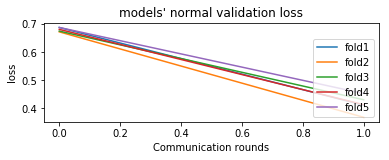

In [18]:
plt.subplot(2,1,1)
for i in range(len(loss_values_averages_all)):
    plt.plot(loss_values_averages_all[i])
plt.title('models\' normal validation loss')
plt.ylabel('loss')
plt.xlabel('Communication rounds')
plt.legend(['fold1', 'fold2','fold3', 'fold4', 'fold5'], loc='lower right')
plt.savefig("Model's Validation loss vs Communication Rounds - Second technique with validation loss - 30 patience")

In [21]:
from sklearn.metrics import classification_report
average_f1_score = 0
#Confution Matrix and Classification Report
for i in range(len(best_models)):
    Y_pred = best_models[i][-1].predict(test_batches_CV[i])
    y_pred = np.where(Y_pred > 0.5, 1, 0)
    print('Confusion Matrix')
    y_pred = y_pred.max(axis=1)
    y_true = np.concatenate([y for x, y in test_batches_CV[i]], axis=0)
    print(confusion_matrix(y_true, y_pred, labels=[True, False]))
    f1_score_acc = f1_score(y_true, y_pred, average='macro')
    average_f1_score += f1_score_acc
    print("F1 Score: {}".format(f1_score_acc))
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))
average_f1_score = average_f1_score / len(best_models)
print("Average F1 Score: {}".format(average_f1_score))


Confusion Matrix
[[ 294   84]
 [  88 3417]]
F1 Score: 0.8745669125711795
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.98      3505
     Class 1       0.77      0.78      0.77       378

    accuracy                           0.96      3883
   macro avg       0.87      0.88      0.87      3883
weighted avg       0.96      0.96      0.96      3883

Confusion Matrix
[[ 300   78]
 [  63 3442]]
F1 Score: 0.8948227124065296
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      3505
     Class 1       0.83      0.79      0.81       378

    accuracy                           0.96      3883
   macro avg       0.90      0.89      0.89      3883
weighted avg       0.96      0.96      0.96      3883

Confusion Matrix
[[ 296   83]
 [  65 3439]]
F1 Score: 0.8894676914318247
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      3504
     Class 1      

FPR:  [0.         0.02510699 1.        ]
TPR:  [0.         0.77777778 1.        ]


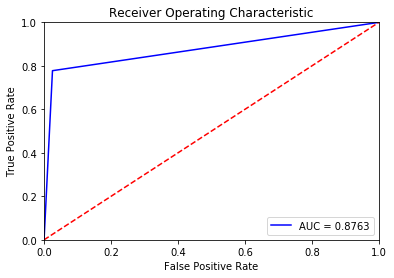

FPR:  [0.         0.01797432 1.        ]
TPR:  [0.         0.79365079 1.        ]


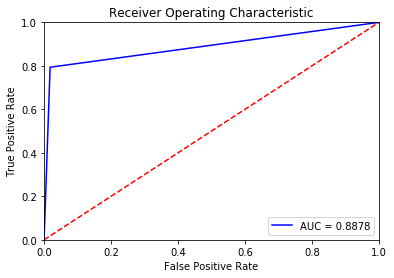

FPR:  [0.         0.01855023 1.        ]
TPR:  [0.         0.78100264 1.        ]


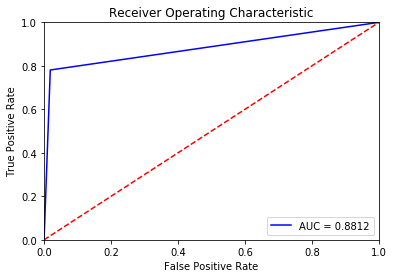

FPR:  [0.         0.02026256 1.        ]
TPR:  [0.         0.78364116 1.        ]


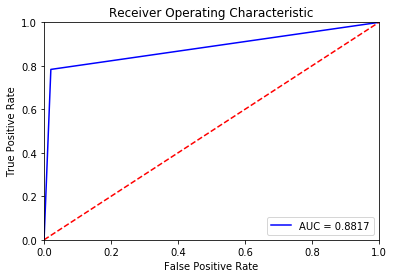

FPR:  [0.         0.02054795 1.        ]
TPR:  [0.         0.79100529 1.        ]


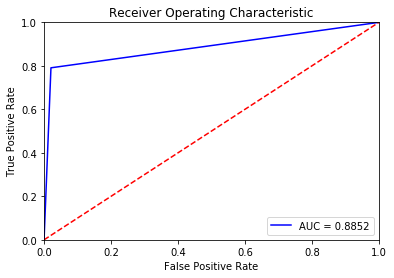

In [22]:
import sklearn.metrics as metrics

for i in range(len(best_models)):
    Y_pred = best_models[i][-1].predict(test_batches_CV[i])
    y_pred = np.where(Y_pred > 0.5, 1, 0)
    y_pred = y_pred.max(axis=1)
    y_true = np.concatenate([y for x, y in test_batches_CV[i]], axis=0)
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print("FPR: ", fpr)
    print("TPR: ", tpr)
    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Precision:  [0.09734741 0.76963351 1.        ]
Recall:  [1.         0.77777778 0.        ]
Logistic: f1=0.875 auc=0.785


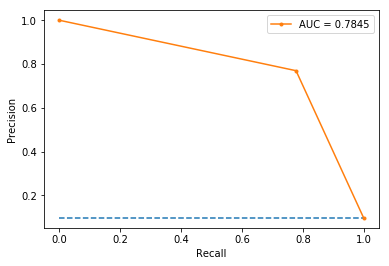

Precision:  [0.09734741 0.82644628 1.        ]
Recall:  [1.         0.79365079 0.        ]
Logistic: f1=0.895 auc=0.820


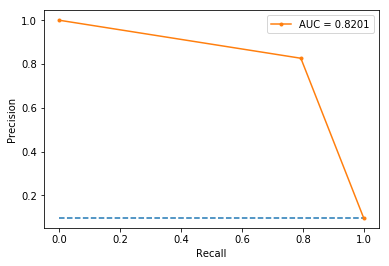

Precision:  [0.09760494 0.8199446  1.        ]
Recall:  [1.         0.78100264 0.        ]
Logistic: f1=0.889 auc=0.811


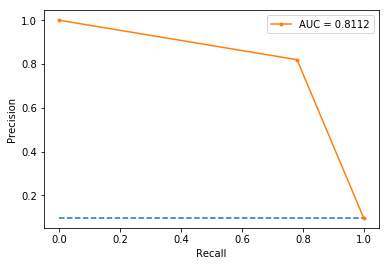

Precision:  [0.09760494 0.80706522 1.        ]
Recall:  [1.         0.78364116 0.        ]
Logistic: f1=0.887 auc=0.806


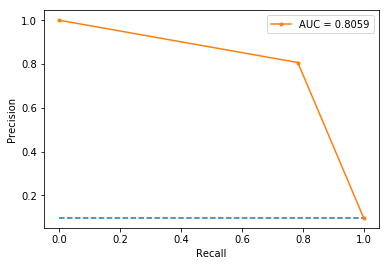

Precision:  [0.09737249 0.80592992 1.        ]
Recall:  [1.         0.79100529 0.        ]
Logistic: f1=0.888 auc=0.809


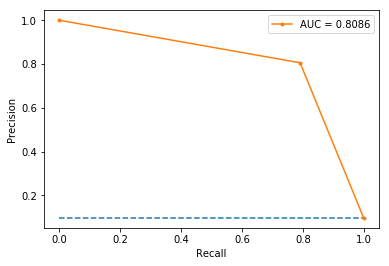

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

for i in range(len(best_models)):
    Y_pred = best_models[i][-1].predict(test_batches_CV[i])
    y_pred = np.where(Y_pred > 0.5, 1, 0)
    y_pred = y_pred.max(axis=1)
    y_true = np.concatenate([y for x, y in test_batches_CV[i]], axis=0)
    lr_precision, lr_recall, _ = precision_recall_curve(y_true, y_pred)
    lr_f1, lr_auc = f1_score(y_true, y_pred, average='macro'), auc(lr_recall, lr_precision)
    # summarize scores
    print("Precision: ", lr_precision)
    print("Recall: ", lr_recall)
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.plot(lr_recall, lr_precision, marker='.', label = 'AUC = %0.4f' % lr_auc)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()